# Dataset

https://raw.githubusercontent.com/SayakKDutta1/BDNS/main/loan_approval_dataset.csv

change


# PYSPARK

In [1]:
!pip3 -q install pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Praxis').getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Praxis>

In [5]:
!wget -O Data_Set.csv -q https://raw.githubusercontent.com/milichowdhury0096/Risk-Mitigation-Analysis-In-Loans-using-Spark/main/loan_approval_dataset.csv #change
# Load and Read the dataset
dfCusCon=spark.read.csv('Data_Set.csv',inferSchema=True,header=True)
# Chech the datatypes of the inputs
dfCusCon.printSchema()

root
 |-- loan_id: integer (nullable = true)
 |--  no_of_dependents: integer (nullable = true)
 |--  education: string (nullable = true)
 |--  self_employed: string (nullable = true)
 |--  income_annum: integer (nullable = true)
 |--  loan_amount: integer (nullable = true)
 |--  loan_term: integer (nullable = true)
 |--  cibil_score: integer (nullable = true)
 |--  residential_assets_value: integer (nullable = true)
 |--  commercial_assets_value: integer (nullable = true)
 |--  luxury_assets_value: integer (nullable = true)
 |--  bank_asset_value: integer (nullable = true)
 |--  loan_status: string (nullable = true)



In [6]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/sparkDB.coll01") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/sparkDB.coll01") \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.1')\
    .getOrCreate()

In [7]:
# Check the shape of the dataset
print((dfCusCon.count(), len(dfCusCon.columns)))

(4269, 13)


In [8]:
# Look at the dataset using SPARK
dfCusCon.show(5)

+-------+-----------------+-------------+--------------+-------------+------------+----------+------------+-------------------------+------------------------+--------------------+-----------------+------------+
|loan_id| no_of_dependents|    education| self_employed| income_annum| loan_amount| loan_term| cibil_score| residential_assets_value| commercial_assets_value| luxury_assets_value| bank_asset_value| loan_status|
+-------+-----------------+-------------+--------------+-------------+------------+----------+------------+-------------------------+------------------------+--------------------+-----------------+------------+
|      1|                2|     Graduate|            No|      9600000|    29900000|        12|         778|                  2400000|                17600000|            22700000|          8000000|    Approved|
|      2|                0| Not Graduate|           Yes|      4100000|    12200000|         8|         417|                  2700000|                 220000

In [9]:
data_types = dfCusCon.dtypes

for column, data_type in data_types:
    print(f"Column: {column}, Data Type: {data_type}")

Column: loan_id, Data Type: int
Column:  no_of_dependents, Data Type: int
Column:  education, Data Type: string
Column:  self_employed, Data Type: string
Column:  income_annum, Data Type: int
Column:  loan_amount, Data Type: int
Column:  loan_term, Data Type: int
Column:  cibil_score, Data Type: int
Column:  residential_assets_value, Data Type: int
Column:  commercial_assets_value, Data Type: int
Column:  luxury_assets_value, Data Type: int
Column:  bank_asset_value, Data Type: int
Column:  loan_status, Data Type: string


#EDA

In [10]:
!pip install plotly
import plotly.express as px

In [11]:
import pandas as pd

df = dfCusCon.toPandas()


In [12]:
# Filter only approved loans
df_approved = df[df[' loan_status'] == ' Approved']

# Create a scatter plot
fig = px.scatter(df_approved, x=' income_annum', y=' loan_amount', title='Income Per Annum vs Loan Amount Approved',
                 labels={' income_annum': 'Income Per Annum', ' loan_amount': 'Loan Amount'})

# Show the plot
fig.show()

In [13]:
df_approved = df[df[' loan_status'] == ' Approved']

# Define CIBIL score ranges
df_approved['cibil_score_range'] = pd.cut(df_approved[' cibil_score'], bins=[0, 500, 600, 700, 800, 900], labels=['<500', '500-600', '600-700', '700-800', '800-900'])

# Group by CIBIL score ranges and calculate average loan amount
grouped_df = df_approved.groupby('cibil_score_range')[' loan_amount'].mean().reset_index()

# Create a bar chart
fig = px.bar(grouped_df, x='cibil_score_range', y=' loan_amount', title='Average Loan Amount by CIBIL Score Range',
             labels={' loan_amount': 'Average Loan Amount', ' cibil_score_range': 'CIBIL Score Range'})
fig.show()

<ipython-input-13-8c013269d516>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



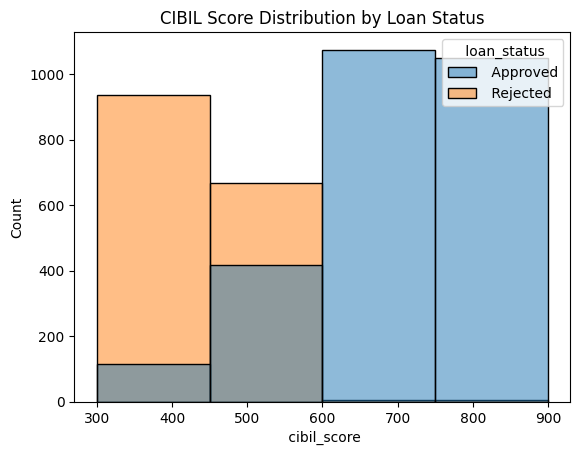

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df, x=' cibil_score', bins=4, hue=' loan_status')
plt.title('CIBIL Score Distribution by Loan Status')
plt.show()

<Axes: xlabel=' no_of_dependents', ylabel='count'>

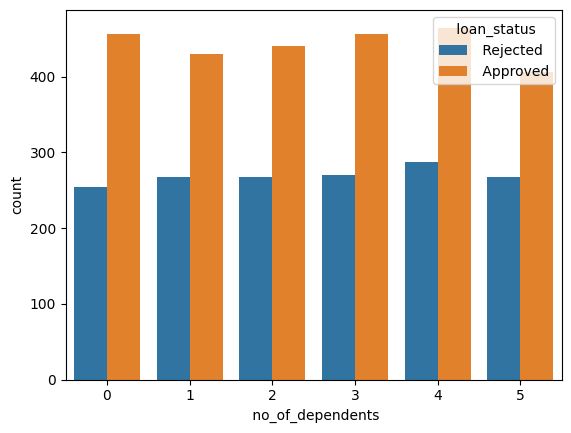

In [15]:
#Drawn the effect of dependents
sns.countplot(x = ' no_of_dependents', data = df, hue = ' loan_status')

# Feature Engineering and Selection

### Calculating the Correlation of Numerical Variables

In [16]:
numerical_columns = df.select_dtypes(include=['int', 'float']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

numerical_columns, categorical_columns

(Index(['loan_id', ' no_of_dependents', ' income_annum', ' loan_amount',
        ' loan_term', ' cibil_score', ' residential_assets_value',
        ' commercial_assets_value', ' luxury_assets_value',
        ' bank_asset_value'],
       dtype='object'),
 Index([' education', ' self_employed', ' loan_status'], dtype='object'))

In [17]:
# Clean up leading spaces in column names
df.columns = df.columns.str.strip()

# Get unique values in each column
unique_education = df['education'].unique()
unique_self_employed = df['self_employed'].unique()


print("Unique values in 'education':", unique_education)
print("Unique values in 'self_employed':", unique_self_employed)


Unique values in 'education': [' Graduate' ' Not Graduate']
Unique values in 'self_employed': [' No' ' Yes']


In [18]:
education_mapping = {' Graduate': 1, ' Not Graduate': 0}
self_employed_mapping = {' Yes': 1, ' No': 0}


# Add new columns with numeric encoding
df['education_num'] = df['education'].map(education_mapping)
df['self_employed_num'] = df['self_employed'].map(self_employed_mapping)

In [19]:
numerical_columns = df.select_dtypes(include=['int', 'float']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

numerical_columns, categorical_columns

(Index(['loan_id', 'no_of_dependents', 'income_annum', 'loan_amount',
        'loan_term', 'cibil_score', 'residential_assets_value',
        'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value',
        'education_num', 'self_employed_num'],
       dtype='object'),
 Index(['education', 'self_employed', 'loan_status'], dtype='object'))

In [20]:
df.head(2)

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status,education_num,self_employed_num
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved,1,0
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected,0,1


In [21]:
# Compute the correlation matrix
corr_matrix = df[numerical_columns].corr()# Compute the correlation matrix
corr_matrix = df[numerical_columns].corr()

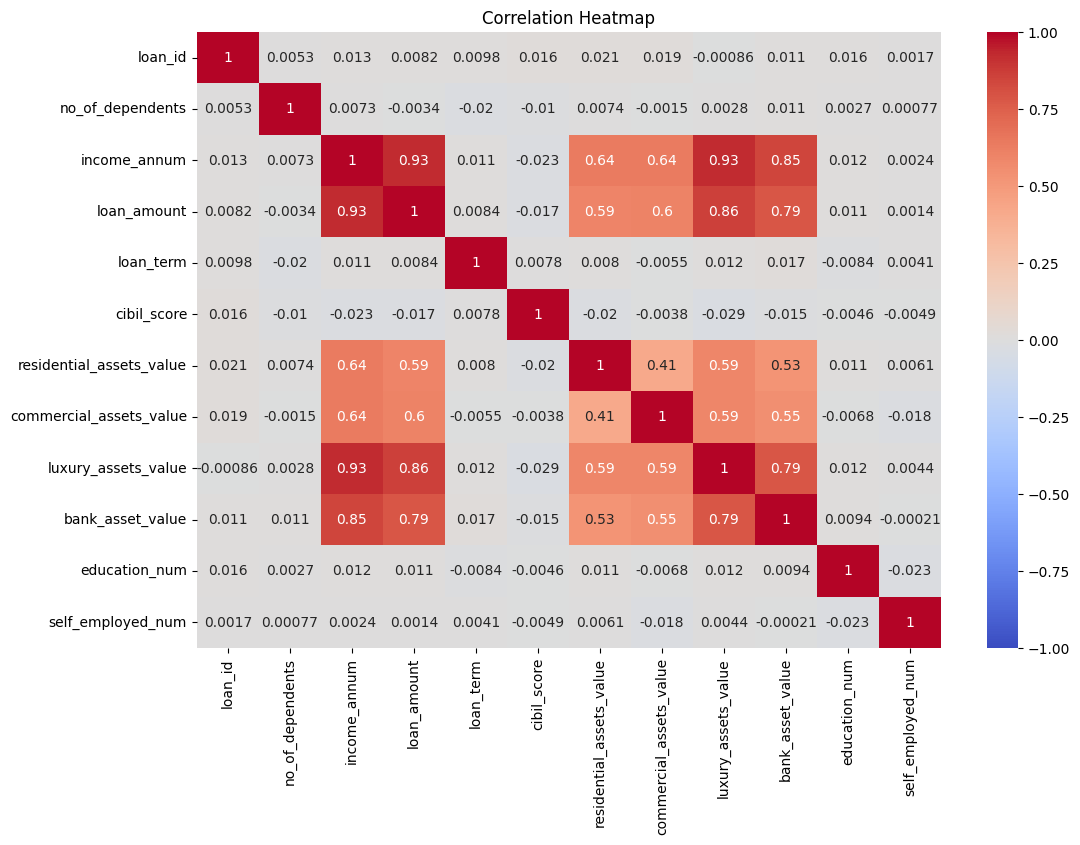

In [22]:
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

## Synopsis of the Correlation Heatmap
The correlation heatmap provided illustrates the Pearson correlation coefficients between various features in a loan dataset.

### Key Observations
### High Positive Correlations:

<br> 1. Income and Loan Amount (0.93)
<br> 2. Income and Luxury Assets Value (0.93)
<br> 3. Income and Bank Asset Value (0.85)
<br> 4. Loan Amount and Luxury Assets Value (0.86)
<br> 5. Loan Amount and Bank Asset Value    (0.79)
<br> 6. Luxury Assets Value and Bank Asset Value (0.79)


### Moderate Positive Correlations:

<br> 1. Income and Residential Assets Value (0.64)
<br> 2. Income and Commercial Assets Value  (0.64)




We drop Loan Amount, Luxury Assets Value, Bank Asset Value, Loan Status, Residential Assets Value, Commercial Assets Value

In [23]:
# Clean up leading spaces in column names (if necessary)
df.columns = df.columns.str.strip()

# List of columns to drop
columns_to_drop = [
    'loan_amount',
    'luxury_assets_value',
    'bank_asset_value',
    'residential_assets_value',
    'commercial_assets_value'
]

# Drop specified columns
df1 = df.drop(columns=columns_to_drop)

In [24]:
df1.head(2)

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_term,cibil_score,loan_status,education_num,self_employed_num
0,1,2,Graduate,No,9600000,12,778,Approved,1,0
1,2,0,Not Graduate,Yes,4100000,8,417,Rejected,0,1


In [25]:
numerical_columns = df1.select_dtypes(include=['int', 'float']).columns
categorical_columns = df1.select_dtypes(include=['object']).columns

numerical_columns, categorical_columns

(Index(['loan_id', 'no_of_dependents', 'income_annum', 'loan_term',
        'cibil_score', 'education_num', 'self_employed_num'],
       dtype='object'),
 Index(['education', 'self_employed', 'loan_status'], dtype='object'))

In [26]:
# Compute the correlation matrix
corr_matrix = df1[numerical_columns].corr()# Compute the correlation matrix
corr_matrix = df1[numerical_columns].corr()

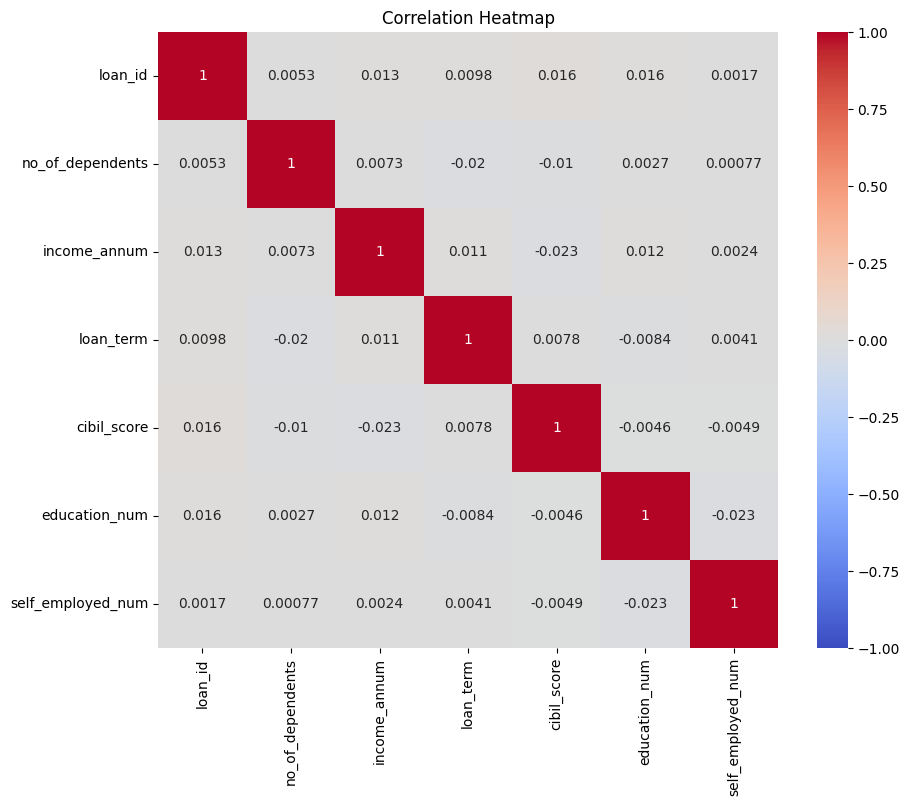

In [27]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [28]:
# Identify categorical columns (dtype 'object' or 'category')
categorical_cols = df1.select_dtypes(include=['object', 'category']).columns

# Drop all categorical columns except 'loan_status'
categorical_cols_to_drop = [col for col in categorical_cols if col != 'loan_status']

# Drop the identified columns
df2 = df1.drop(columns=categorical_cols_to_drop)


In [29]:
df2.head(2)

,loan_id,no_of_dependents,income_annum,loan_term,cibil_score,loan_status,education_num,self_employed_num
0,1,2,9600000,12,778,Approved,1,0
1,2,0,4100000,8,417,Rejected,0,1


# Pipeline, Estimator, Transformer

In [30]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline


In [31]:
df3= spark.createDataFrame(df2)

In [32]:
df3.show(5,False)

+-------+----------------+------------+---------+-----------+-----------+-------------+-----------------+
|loan_id|no_of_dependents|income_annum|loan_term|cibil_score|loan_status|education_num|self_employed_num|
+-------+----------------+------------+---------+-----------+-----------+-------------+-----------------+
|1      |2               |9600000     |12       |778        | Approved  |1            |0                |
|2      |0               |4100000     |8        |417        | Rejected  |0            |1                |
|3      |3               |9100000     |20       |506        | Rejected  |1            |0                |
|4      |3               |8200000     |8        |467        | Rejected  |1            |0                |
|5      |5               |9800000     |20       |382        | Rejected  |0            |1                |
+-------+----------------+------------+---------+-----------+-----------+-------------+-----------------+
only showing top 5 rows



In [33]:
data_types = df3.dtypes

for column, data_type in data_types:
    print(f"Column: {column}, Data Type: {data_type}")

Column: loan_id, Data Type: bigint
Column: no_of_dependents, Data Type: bigint
Column: income_annum, Data Type: bigint
Column: loan_term, Data Type: bigint
Column: cibil_score, Data Type: bigint
Column: loan_status, Data Type: string
Column: education_num, Data Type: bigint
Column: self_employed_num, Data Type: bigint


In [34]:
from pyspark.sql.functions import col

# Calculate the total sum of null values in the entire DataFrame
total_null_count = df3.select([col(c).isNull().cast("int") for c in df3.columns]).rdd.flatMap(lambda x: x).sum()

# Display the total sum of null values
print("Total sum of null values in the DataFrame:", total_null_count)


Total sum of null values in the DataFrame: 0


In [35]:
education_indexer = StringIndexer(inputCol=" education", outputCol="edu")
education_encoder  = OneHotEncoder(inputCol="edu", outputCol="edu_Vector")
education_encoder.setDropLast(False)

self_employed_indexer = StringIndexer(inputCol=" self_employed", outputCol="self_employed1")
self_employed_encoder  = OneHotEncoder(inputCol="self_employed1", outputCol="self_employed1_Vector")
self_employed_encoder.setDropLast(False)

loan_status_indexer = StringIndexer(inputCol=" loan_status", outputCol="loan_status1")
loan_status_encoder  = OneHotEncoder(inputCol="loan_status1", outputCol="loan_status1_Vector")

Feature_assembler = VectorAssembler(inputCols=['edu_Vector','self_employed1_Vector','loan_id',\
                                               ' no_of_dependents', ' income_annum', ' loan_amount', ' loan_term', ' cibil_score', \
                                               ' residential_assets_value', ' commercial_assets_value', ' luxury_assets_value', ' bank_asset_value'], outputCol="features")


In [36]:
dfTrainP, dfTestP = dfCusCon.randomSplit([0.75,0.25])
print( dfTrainP.count(), dfTestP.count())

3223 1046


1 DECISION TREE

In [37]:
from pyspark.ml.classification import DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(featuresCol="features", labelCol="loan_status1")

In [38]:
mlPipeLine1 = Pipeline(stages=[education_indexer,education_encoder, self_employed_indexer, self_employed_encoder, loan_status_indexer,\
                              loan_status_encoder,\
                              Feature_assembler])

In [39]:
mlPipeLine1.fit(dfCusCon).transform(dfCusCon).show(5)

+-------+-----------------+-------------+--------------+-------------+------------+----------+------------+-------------------------+------------------------+--------------------+-----------------+------------+---+-------------+--------------+---------------------+------------+-------------------+--------------------+
|loan_id| no_of_dependents|    education| self_employed| income_annum| loan_amount| loan_term| cibil_score| residential_assets_value| commercial_assets_value| luxury_assets_value| bank_asset_value| loan_status|edu|   edu_Vector|self_employed1|self_employed1_Vector|loan_status1|loan_status1_Vector|            features|
+-------+-----------------+-------------+--------------+-------------+------------+----------+------------+-------------------------+------------------------+--------------------+-----------------+------------+---+-------------+--------------+---------------------+------------+-------------------+--------------------+
|      1|                2|     Graduate

In [40]:
mlPipeLine = Pipeline(stages=[mlPipeLine1,dt_classifier])
# training model pipeline with data
                                                                 # mlPipeLine = Estimator
                                                                 # mlPipeLine.fit(dfTrainP), the fitted pipeline is the Transformer
mlModel = mlPipeLine.fit(dfTrainP)
TestResults = mlModel.transform(dfTestP)

In [41]:
tp = TestResults[(TestResults.loan_status1 == 1.0) & (TestResults.prediction == 1)].count()
tn = TestResults[(TestResults.loan_status1 == 0.0) & (TestResults.prediction == 0)].count()
fp = TestResults[(TestResults.loan_status1 == 0.0) & (TestResults.prediction == 1)].count()
fn = TestResults[(TestResults.loan_status1 == 1.0) & (TestResults.prediction == 0)].count()

In [42]:
accuracy_dt=float((tp+tn) /(TestResults.count()))
print('Accuracy with Pipeline = ',accuracy_dt)

Accuracy with Pipeline =  0.9608030592734226


In [43]:
recall_dt = float(tp)/(tp + fn)
print('Recall with Pipeline = ',recall_dt)

Recall with Pipeline =  0.9673366834170855


In [44]:
FPR_dt = float(fp) / (tn + fp)
print('False Positive rate with Pipeline = ',FPR_dt)

False Positive rate with Pipeline =  0.043209876543209874


In [45]:
print('Accuracy_DecisionTREE :', round(accuracy_dt,2), ' (with Pipeline) ', round(accuracy_dt,2),' (without)')
print('Recall_DecisionTREE    :', round(recall_dt,2), ' (with Pipeline) ', round(recall_dt,2),' (without)')
print('FalsePositiveRate_DecisionTREE :', round(FPR_dt,2), ' (with Pipeline) ', round(FPR_dt,2),' (without)')

Accuracy_DecisionTREE : 0.96  (with Pipeline)  0.96  (without)
Recall_DecisionTREE    : 0.97  (with Pipeline)  0.97  (without)
FalsePositiveRate_DecisionTREE : 0.04  (with Pipeline)  0.04  (without)


2. Random Forest

In [46]:
from pyspark.ml.classification import RandomForestClassifier
random_forest = RandomForestClassifier(labelCol='loan_status1', featuresCol='features', numTrees=100)

In [47]:
dfTrainP, dfTestP = dfCusCon.randomSplit([0.75,0.25])
print( dfTrainP.count(), dfTestP.count())

3243 1026


In [48]:
mlPipeLine = Pipeline(stages=[mlPipeLine1 ,random_forest])
# training model pipeline with data
                                                                 # mlPipeLine = Estimator
                                                                 # mlPipeLine.fit(dfTrainP), the fitted pipeline is the Transformer
mlModel = mlPipeLine.fit(dfTrainP)
TestResults = mlModel.transform(dfTestP)

In [49]:
tp = TestResults[(TestResults.loan_status1 == 1.0) & (TestResults.prediction == 1)].count()
tn = TestResults[(TestResults.loan_status1 == 0.0) & (TestResults.prediction == 0)].count()
fp = TestResults[(TestResults.loan_status1 == 0.0) & (TestResults.prediction == 1)].count()
fn = TestResults[(TestResults.loan_status1 == 1.0) & (TestResults.prediction == 0)].count()

In [50]:
accuracy_rf=float((tp+tn) /(TestResults.count()))

recall_rf = float(tp)/(tp + fn)

FPR_rf = float(fp) / (tn + fp)


In [51]:
print('Accuracy_RF :', round(accuracy_rf,2), ' (with Pipeline) ', round(accuracy_rf,2),' (without)')
print('Recall_RF    :', round(recall_rf,2), ' (with Pipeline) ', round(recall_rf,2),' (without)')
print('FalsePositiveRate_RF :', round(FPR_rf,2), ' (with Pipeline) ', round(FPR_rf,2),' (without)')

Accuracy_RF : 0.96  (with Pipeline)  0.96  (without)
Recall_RF    : 0.95  (with Pipeline)  0.95  (without)
FalsePositiveRate_RF : 0.03  (with Pipeline)  0.03  (without)


3. GBM

In [52]:
from pyspark.ml.classification import GBTClassifier
gbm = GBTClassifier(labelCol='loan_status1', featuresCol='features', maxIter=100)

In [53]:
dfTrainP, dfTestP = dfCusCon.randomSplit([0.75,0.25])
print( dfTrainP.count(), dfTestP.count())

3210 1059


In [54]:
mlPipeLine = Pipeline(stages=[mlPipeLine1 ,gbm])
# training model pipeline with data
                                                                 # mlPipeLine = Estimator
                                                                 # mlPipeLine.fit(dfTrainP), the fitted pipeline is the Transformer
mlModel = mlPipeLine.fit(dfTrainP)
TestResults = mlModel.transform(dfTestP)

In [55]:
tp = TestResults[(TestResults.loan_status1 == 1.0) & (TestResults.prediction == 1)].count()
tn = TestResults[(TestResults.loan_status1 == 0.0) & (TestResults.prediction == 0)].count()
fp = TestResults[(TestResults.loan_status1 == 0.0) & (TestResults.prediction == 1)].count()
fn = TestResults[(TestResults.loan_status1 == 1.0) & (TestResults.prediction == 0)].count()

In [56]:
accuracy_rf=float((tp+tn) /(TestResults.count()))

recall_rf = float(tp)/(tp + fn)

FPR_rf = float(fp) / (tn + fp)

In [57]:
print('Accuracy_RF :', round(accuracy_rf,2), ' (with Pipeline) ', round(accuracy_rf,2),' (without)')
print('Recall_RF    :', round(recall_rf,2), ' (with Pipeline) ', round(recall_rf,2),' (without)')
print('FalsePositiveRate_RF :', round(FPR_rf,2), ' (with Pipeline) ', round(FPR_rf,2),' (without)')

Accuracy_RF : 0.97  (with Pipeline)  0.97  (without)
Recall_RF    : 0.95  (with Pipeline)  0.95  (without)
FalsePositiveRate_RF : 0.02  (with Pipeline)  0.02  (without)
